# **Quantum Image Classification**

## **1. Importing Dependencies**

In [1]:
# General imports
import os
import gzip
import numpy as np
import matplotlib.pyplot as plt
from pylab import cm
import warnings
import tensorflow as tf

warnings.filterwarnings("ignore", message="A NumPy version.*")

# scikit-learn imports
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Qiskit imports
from qiskit import IBMQ
from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2
from qiskit.circuit.library import HGate, RXGate, RYGate, RZGate, CXGate, CRXGate, CRZGate
from qiskit_machine_learning.kernels import QuantumKernel
from tensorflow.keras.datasets import mnist

/Users/Shriram/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## **2. Data**

#### **Load MNIST Dataset**

In [2]:
(sample_train, labels_train), (sample_test, labels_test) = mnist.load_data()
print("Training Sample Shape: ", sample_train.shape)
print("Training Labels Shape: ", labels_train.shape)
print("Testing Sample Shape: ", sample_test.shape)
print("Testing Labels Shape: ", labels_test.shape)

Training Sample Shape:  (60000, 28, 28)
Training Labels Shape:  (60000,)
Testing Sample Shape:  (10000, 28, 28)
Testing Labels Shape:  (10000,)


In [3]:
# Picking only the first 50 images for Training and 10 images for Testing
sample_train = sample_train[:50]
labels_train = labels_train[:50]
sample_test = sample_test[:10]
labels_test = labels_test[:10]

In [4]:
print("Training Sample Shape: ", sample_train.shape)
print("Training Labels Shape: ", labels_train.shape)
print("Testing Sample Shape: ", sample_test.shape)
print("Testing Labels Shape: ", labels_test.shape)

Training Sample Shape:  (50, 28, 28)
Training Labels Shape:  (50,)
Testing Sample Shape:  (10, 28, 28)
Testing Labels Shape:  (10,)


In [5]:
# Splitting Training data into Training and Validation
sample_train, sample_val, labels_train, labels_val = train_test_split(sample_train, labels_train, test_size=0.2, random_state=42)

In [6]:
sample_train = sample_train.reshape(40,784)
sample_val = sample_val.reshape(10,784)
sample_test = sample_test.reshape(10,784)

#### **Visualization**

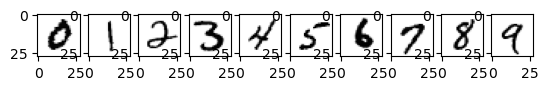

In [7]:
# Visualize samples
fig = plt.figure()

LABELS = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
num_labels = len(LABELS)
for i in range(num_labels):
    ax = fig.add_subplot(1, num_labels, i+1)
    img = sample_train[labels_train==LABELS[i]][0].reshape((28, 28))
    ax.imshow(img, cmap="Greys")

#### **Data pre-processing**

In [8]:
# Standardize
standard_scaler = StandardScaler()
sample_train = standard_scaler.fit_transform(sample_train)
sample_val = standard_scaler.transform(sample_val)
sample_test = standard_scaler.transform(sample_test)

In [9]:
# Reduce dimensions
N_DIM = 5
pca = PCA(n_components=N_DIM)
sample_train = pca.fit_transform(sample_train)
sample_val = pca.transform(sample_val)
sample_test = pca.transform(sample_test)

In [10]:
# Normalize
min_max_scaler = MinMaxScaler((-1, 1))
sample_train = min_max_scaler.fit_transform(sample_train)
sample_val = min_max_scaler.transform(sample_val)
sample_test = min_max_scaler.transform(sample_test)

## **3. Quantum Kernel-based Classification**

In [11]:
LABELS = [9, 8, 7, 6 ,5 ,4 ,3 ,2, 1, 0]
list = []
num_labels = len(LABELS)
for i in range(num_labels):

    labels_train_u = np.where(labels_train==LABELS[i], 1, 0)
    labels_val_u = np.where(labels_val==LABELS[i], 1, 0)
    print(f'Original validation labels:      {labels_val}')
    print(f'Validation labels for 0 vs Rest: {labels_val_u}')
    
    ZZfeat_map = ZZFeatureMap(feature_dimension=N_DIM, reps=3, entanglement='circular')
    kernel = QuantumKernel(feature_map=ZZfeat_map, quantum_instance=Aer.get_backend('qasm_simulator'))  
    
    svc = SVC(kernel='precomputed', probability=True)
    
    matrix_train = kernel.evaluate(x_vec=sample_train)
    svc.fit(matrix_train, labels_train_u)
    
    matrix_val = kernel.evaluate(x_vec=sample_val, y_vec=sample_train)
    zzfeat_score = svc.score(matrix_val, labels_val_u)
    print(f'Accuracy of discriminating between label and others: {zzfeat_score*100}%')
    
    matrix_test = kernel.evaluate(x_vec=sample_test, y_vec=sample_train)
    pred = svc.predict_proba(matrix_test)[:, 1]
    print(f'Probability of label: {np.round(pred, 2)}')
    
    list.append(pred)

Original validation labels:      [6 6 3 9 8 9 4 2 6 9]
Validation labels for 0 vs Rest: [0 0 0 1 0 1 0 0 0 1]
Accuracy of discriminating between label and others: 70.0%
Probability of label: [0.11 0.1  0.1  0.11 0.11 0.11 0.1  0.11 0.11 0.1 ]
Original validation labels:      [6 6 3 9 8 9 4 2 6 9]
Validation labels for 0 vs Rest: [0 0 0 0 1 0 0 0 0 0]
Accuracy of discriminating between label and others: 90.0%
Probability of label: [0.1  0.07 0.08 0.06 0.09 0.09 0.08 0.09 0.06 0.06]
Original validation labels:      [6 6 3 9 8 9 4 2 6 9]
Validation labels for 0 vs Rest: [0 0 0 0 0 0 0 0 0 0]
Accuracy of discriminating between label and others: 100.0%
Probability of label: [0.04 0.11 0.04 0.05 0.09 0.15 0.06 0.16 0.08 0.09]
Original validation labels:      [6 6 3 9 8 9 4 2 6 9]
Validation labels for 0 vs Rest: [1 1 0 0 0 0 0 0 1 0]
Accuracy of discriminating between label and others: 70.0%
Probability of label: [0.06 0.05 0.07 0.06 0.08 0.07 0.06 0.06 0.06 0.06]
Original validation labels:

## **4. Visualization**

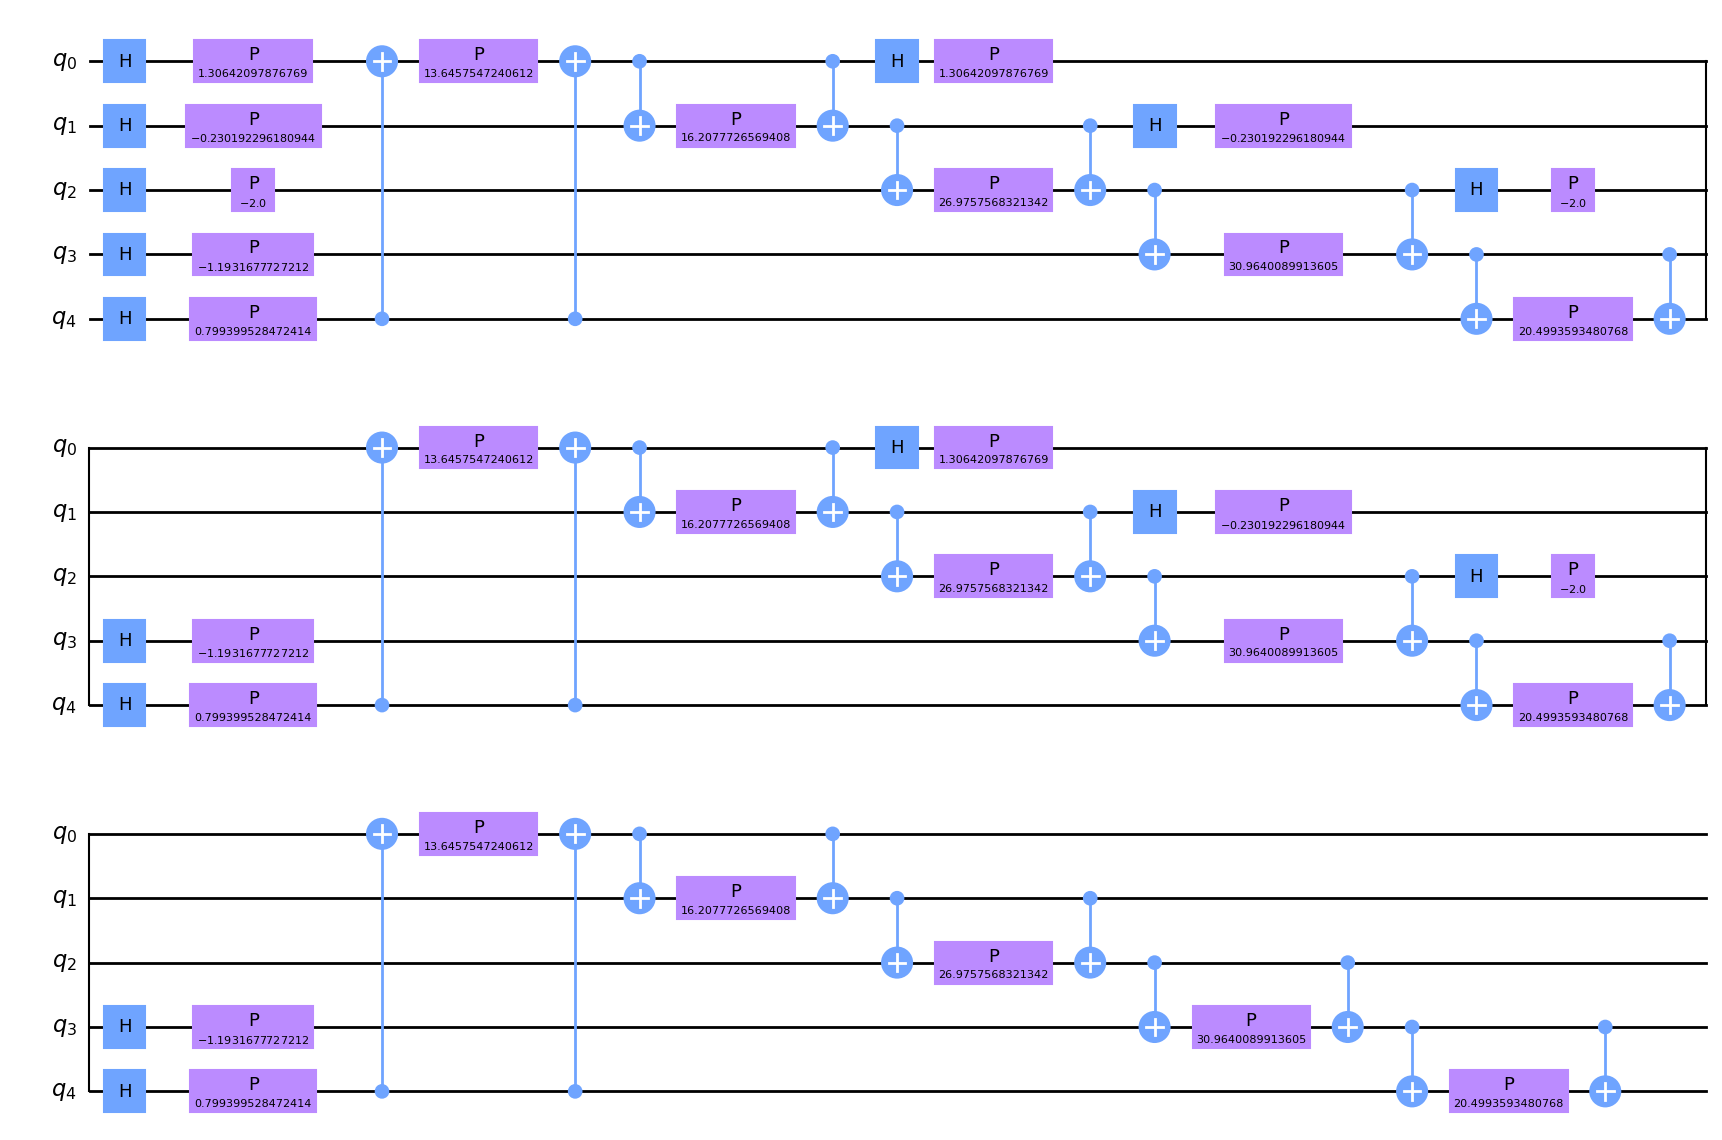

In [12]:
encode_circuit = ZZfeat_map.bind_parameters(sample_train[0])
encode_circuit.decompose().draw(output='mpl')